# OCC One-class classification
Laden von Datensatz WELFake

In [25]:
import pandas as pd
import numpy as np
import os

# One-class models
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



path = os.path.join("../src/data", "Saurabh Shahane - Fake_News_Classification", "WELFake_Dataset.csv")

df = pd.read_csv(path)
df = df.rename(columns={'Title': 'title', 'Text': 'text', 'Label': 'label'})
df = df[df['text'].notna() & df['title'].notna()]
df['label'] = 1 - df['label'].astype(int)  # Flip labels: 0 → 1, 1 → 0
df = df[['title', 'text', 'label']]

df = df.sample(frac=0.1, random_state=42)

# Split full DataFrame
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

# Keep only training rows with label == 1
df_train = df_train[df_train['label'] == 1]

# Create input features
X_train = df_train['title'] + '\n' + df_train['text']
y_train = df_train['label']

X_val = df_val['title'] + '\n' + df_val['text']
y_val = df_val['label']




# Vectorize text
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec   = vectorizer.transform(X_val)

def evaluate_model(name, preds, y_true):
    print(f"== {name} ==")
    print(classification_report(y_true, preds, target_names=["Fake", "Real"]))

contamination = min(1 - df['label'].mean(), 0.5)

## Isolation forest

In [3]:
model_if = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
model_if.fit(X_train_vec)

preds_if = model_if.predict(X_val_vec)
preds_if = (preds_if == 1).astype(int)

evaluate_model('IsolationForest', preds_if, y_val)

== IsolationForest ==
              precision    recall  f1-score   support

        Fake       0.46      0.40      0.43       715
        Real       0.47      0.54      0.51       716

    accuracy                           0.47      1431
   macro avg       0.47      0.47      0.47      1431
weighted avg       0.47      0.47      0.47      1431



## Local Outlier Factor

In [27]:
model_lof = LocalOutlierFactor(n_neighbors=15, contamination=contamination, novelty=True)
model_lof.fit(X_train_vec)
preds_lof = model_lof.predict(X_val_vec)
preds_lof = (preds_lof == 1).astype(int)
evaluate_model('LocalOutlierFactor', preds_lof, y_val)

== LocalOutlierFactor ==
              precision    recall  f1-score   support

        Fake       0.61      0.76      0.68       715
        Real       0.68      0.53      0.59       716

    accuracy                           0.64      1431
   macro avg       0.65      0.64      0.64      1431
weighted avg       0.65      0.64      0.64      1431



## Nearest Neighbors

In [5]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 1) Fit KNN with sparse inputs and cosine metric
knn = NearestNeighbors(n_neighbors=5)
knn.fit(X_train_vec)

# 2) Compute distances (sparse→sparse)
distances, _ = knn.kneighbors(X_val_vec)

# 3) Average distance as anomaly score
avg_dist = distances.mean(axis=1)

# 4) Threshold top 20% as outliers
thresh_knn = np.percentile(avg_dist, 80)
preds_knn  = (avg_dist < thresh_knn).astype(int)

# 5) Evaluate
evaluate_model('KNN Distance', preds_knn, y_val)


== KNN Distance ==
              precision    recall  f1-score   support

        Fake       0.81      0.32      0.46       715
        Real       0.58      0.92      0.71       716

    accuracy                           0.62      1431
   macro avg       0.69      0.62      0.59      1431
weighted avg       0.69      0.62      0.59      1431



# Local Outlier Factor (LOF) Hyperparametertuning
## Local Outlier Factor

Der **Local Outlier Factor (LOF)** ist ein Dichte-basiertes Verfahren zur Erkennung von Anomalien. 
Es vergleicht die lokale Dichte eines Datenpunkts mit derjenigen seiner Nachbarn. 
Punkte, die in Regionen deutlich geringerer Dichte liegen als ihre Nachbarn, 
erhalten einen hohen LOF‑Wert und werden als Ausreißer klassifiziert.

LOF basiert auf folgenden Konzepten:

1. **k‑Distanz eines Punktes**: Die Entfernung zum *k*-nächsten Nachbarn.
2. **k‑Nächste Nachbarn (kNN)**: Die Menge der *k* nächsten Datenpunkte eines Punktes.
3. **Erreichbarkeitsdistanz** (reachability distance):  
   $$
   \mathrm{reach\mbox{-}dist}_k(p, o) \;=\; \max\bigl(\mathrm{k\mbox{-}dist}(o),\, \mathrm{dist}(p, o)\bigr)
   $$
4. **Lokale Erreichbarkeitsdichte** (local reachability density, LRD):  
   $$
   \mathrm{lrd}_k(p)
   \;=\;
   \frac{1}{\displaystyle\frac{1}{|N_k(p)|}\sum_{o\in N_k(p)}\mathrm{reach\mbox{-}dist}_k(p,o)}
   $$
5. **Local Outlier Factor**:  
   $$
   \mathrm{LOF}_k(p)
   \;=\;
   \frac{\displaystyle\sum_{o\in N_k(p)}\frac{\mathrm{lrd}_k(o)}{\mathrm{lrd}_k(p)}}{|N_k(p)|}
   $$

Ein LOF‑Wert nahe 1 bedeutet, dass die Punktdichte von \(p\) derjenigen seiner Nachbarn entspricht → **kein Ausreißer**. 
Werte deutlich größer als 1 deuten auf **Anomalien** hin.

---

![LOF Grafik](./Bilder/LOF.png)

*Quelle: [Local Outlier Factor – Wikipedia](https://de.wikipedia.org/wiki/Local_Outlier_Factor)*  


## Interessierende Parameter für LOC
- **n_neighbors** (int, default=20)  
  Anzahl der Nachbarn, die standardmäßig für `kneighbors`-Abfragen verwendet werden. Ist `n_neighbors` größer als die Anzahl der Samples, werden alle Samples berücksichtigt.

- **contamination** (‘auto’ or float, default=’auto’)  
  Erwarteter Anteil an Ausreißern im Datensatz, der die Schwelle für Ausreißerbestimmung festlegt.  
  - Bei `'auto'` wird der Schwellenwert gemäß dem Originalpapier bestimmt.  
  - Bei einem Float-Wert muss `0 < contamination ≤ 0.5` gelten.




# Grid Search

In [21]:
# 1. Imports
import pandas as pd
import numpy as np

# Train/validation split
from sklearn.model_selection import train_test_split

# Text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# One-class classifier and evaluation metrics
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pipeline utilities
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import LocalOutlierFactor
import os

from scipy.stats import randint, uniform
from sklearn.experimental import enable_halving_search_cv  # Needed to enable
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

path = os.path.join("../src/data", "Saurabh Shahane - Fake_News_Classification", "WELFake_Dataset.csv")

df = pd.read_csv(path)
df = df.sample(frac=0.1, random_state=42)
df = df.rename(columns={'Title': 'title', 'Text': 'text', 'Label': 'label'})
df = df[df['text'].notna() & df['title'].notna()]
df['label'] = 1 - df['label'].astype(int)  # Flip labels: 0 → 1, 1 → 0

# Keep only relevant columns
df = df[['title', 'text', 'label']]

# Split into train/temp (30% temp), stratified by label
df_train, df_temp = train_test_split(
    df,
    test_size=0.30,
    stratify=df['label'],
    random_state=42
)

# Filter training data to only label == 1
df_train = df_train[df_train['label'] == 1]

# Generate train inputs
X_train = df_train['title'] + '\n' + df_train['text']
y_train = df_train['label']

# Now split the temp set into val and test (each 15% of original), still stratified
df_val, df_test = train_test_split(
    df_temp,
    test_size=0.50,
    stratify=df_temp['label'],
    random_state=42
)

# Generate val/test inputs
X_val = df_val['title'] + '\n' + df_val['text']
y_val = df_val['label']

X_test = df_test['title'] + '\n' + df_test['text']
y_test = df_test['label']


# 3) Build the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    # novelty=True lets LOF be used for prediction on unseen data
    ('lof', LocalOutlierFactor(novelty=True))
])

# 4) Evaluation function
def evaluate_lof_params(params):
    # build vectorizer + LOF (novelty mode)
    vec = TfidfVectorizer(
        max_features=params['tfidf__max_features'],
        ngram_range=params['tfidf__ngram_range'],
        stop_words='english'
    )
    lof = LocalOutlierFactor(
        n_neighbors=params['lof__n_neighbors'],
        contamination=params['lof__contamination'],
        novelty=True
    )
    
    # fit on real‐only training
    Xtr = vec.fit_transform(X_train)            # X_train = real+fake ∪ but LOF novelty uses only X_train
    lof.fit(Xtr.toarray())                      # LOF requires dense when novelty=True
    
    # transform validation
    Xv = vec.transform(X_val)
    raw = lof.predict(Xv.toarray())             # +1=inlier→Real, -1=outlier→Fake
    y_pred = np.where(raw==1, 1, 0)
    
    return accuracy_score(y_val, y_pred)

In [22]:
param_grid = {
    'tfidf__max_features': [20_000, 30_000],
    'lof__n_neighbors'   : [20, 40],
    'lof__contamination' : [0.4, 0.5]
}

In [23]:
best_score  = -1
best_params = None
total = np.prod([len(v) for v in param_grid.values()])
i = 0

for mf in param_grid['tfidf__max_features']:
        for nn in param_grid['lof__n_neighbors']:
            for cont in param_grid['lof__contamination']:
                i += 1
                p = {
                    'tfidf__max_features': mf,
                    'tfidf__ngram_range': (1,1),
                    'lof__n_neighbors': nn,
                    'lof__contamination': cont
                }
                score = evaluate_lof_params(p)
                print(f"[{i}/{total}] {p} → Val acc: {score:.4f}")
                if score > best_score:
                    best_score, best_params = score, p.copy()

print("\nBest validation accuracy:", best_score)
print("Best parameters:", best_params)

[1/8] {'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 1), 'lof__n_neighbors': 20, 'lof__contamination': 0.4} → Val acc: 0.6313
[2/8] {'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 1), 'lof__n_neighbors': 20, 'lof__contamination': 0.5} → Val acc: 0.6331
[3/8] {'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 1), 'lof__n_neighbors': 40, 'lof__contamination': 0.4} → Val acc: 0.6611
[4/8] {'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 1), 'lof__n_neighbors': 40, 'lof__contamination': 0.5} → Val acc: 0.6536
[5/8] {'tfidf__max_features': 30000, 'tfidf__ngram_range': (1, 1), 'lof__n_neighbors': 20, 'lof__contamination': 0.4} → Val acc: 0.6331
[6/8] {'tfidf__max_features': 30000, 'tfidf__ngram_range': (1, 1), 'lof__n_neighbors': 20, 'lof__contamination': 0.5} → Val acc: 0.6313
[7/8] {'tfidf__max_features': 30000, 'tfidf__ngram_range': (1, 1), 'lof__n_neighbors': 40, 'lof__contamination': 0.4} → Val acc: 0.6620
[8/8] {'tfidf__max_features': 30000, 'tfidf__ngr

### Hyperparameter-Suchverfahren mit Cross‑Validation

- **GridSearchCV**  
  Systematische Durchmusterung aller definierten Parameterkombinationen.  
  - Führt für jede Kombination eine K‑fache Cross‑Validation durch.  
  - Sucht den Parameter-Satz mit der besten durchschnittlichen Performance (z. B. Accuracy, F1-Score).

- **RandomizedSearchCV**  
  Zufällige Auswahl einer festgelegten Anzahl von Parameterkombinationen aus dem Suchraum.  
  - Spart Rechenzeit bei großen Suchräumen.  
  - Bewertet jede Stichprobe per K‑facher Cross‑Validation.

- **HalvingGridSearchCV**  
  „Successive Halving“-Ansatz auf dem Grid-Search-Prinzip:  
  1. Startet mit allen Kombinationen bei kleinem Ressourcenbudget (z. B. Folds oder Iterationen).  
  2. Behalt nur die besten x % der Parameterkonfigurationen für die nächste Runde.  
  3. Erhöht schrittweise das Ressourcenbudget für verbleibende Kandidaten.  
  - Effizienter als vollständige Grid-Search, da schlechte Konfigurationen früh ausscheiden.

- **HalvingRandomSearchCV**  
  Kombination aus RandomizedSearch und Successive Halving:  
  1. Probiere zufällig ausgewählte Parameterkombinationen mit kleinem Budget.  
  2. Selektiere die besten für weitere Evaluierungsrunden mit mehr Ressourcen.  
  - Sehr ressourcenschonend bei großen, unbekannten Suchräumen.

> **Cross‑Validation** (CV)  
>  
> Bei allen oben genannten Verfahren wird die Zuverlässigkeit der Modellbewertung durch K‑fache Cross‑Validation erhöht:  
> 1. Das Trainingsset wird in K Teilmengen (“Folds”) aufgeteilt.  
> 2. K‑mal wird je ein Fold als Validierung und die übrigen als Training verwendet.  
> 3. Die Metriken aller Durchläufe werden gemittelt, um das Overfitting einzelner Splits zu reduzieren und robustere Parameterentscheidungen zu ermöglichen.


# Regression und Random Forest
---
---
---
---
---

# Auswahl der Datensätze zur Validierung

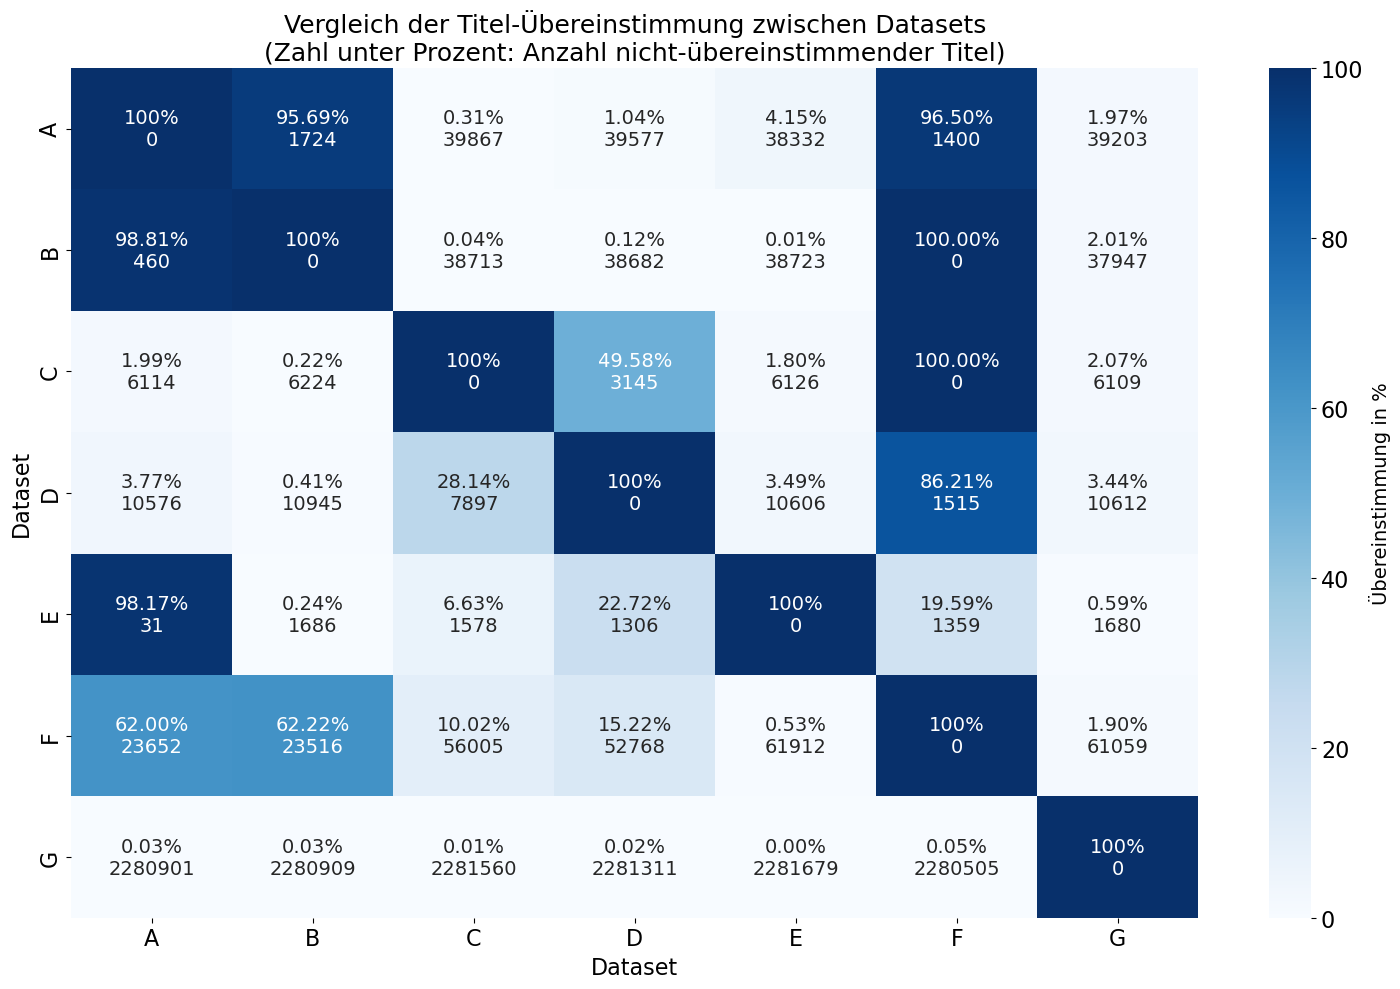

In [31]:
import os
import pandas as pd

from datasets import load_dataset
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def load_datasets(basepath):
    datasets = {}

    # 1. Aadya Singh_Fakenews: evaluation.csv, test (1).csv, train (2).csv
    folder = os.path.join(basepath, "Aadya Singh  _fake-and_real_news")
    files = ["evaluation.csv", "test (1).csv", "train (2).csv"]
    dfs = [pd.read_csv(os.path.join(folder, f), sep=';') for f in files]
    datasets['A'] = pd.concat(dfs, ignore_index=True)

    # 3. clmentbisaillon_Fakenews
    folder = os.path.join(basepath, "clmentbisaillon_Fakenews")
    true = pd.read_csv(os.path.join(folder, "True.csv"))
    fake = pd.read_csv(os.path.join(folder, "Fake.csv"))
    df3 = pd.concat([true, fake], ignore_index=True)
    if 'text' in df3.columns:
        df3 = df3[df3['text'] != "[empty]"]
    datasets['B'] = df3

    # 6. Hassan Amin - fake_or_real_news.csv
    datasets['C'] = pd.read_csv(
        os.path.join(basepath, "Hassan Amin-fake_or_real_news.csv/fake_or_real_news.csv")
    )

    # 7. Meg Risdal_fake_only
    folder = os.path.join(basepath, "Meg Risdal_fake_only")
    df7 = pd.read_csv(os.path.join(folder, "fake.csv"))
    # Drop null titles and non-English
    if 'titel' in df7.columns:
        df7 = df7.dropna(subset=['titel'])
        df7 = df7.rename(columns={'titel': 'title'})
    if 'language' in df7.columns:
        df7 = df7[df7['language'].str.lower() == 'english']
    datasets['D'] = df7
    
    # 8. Ruchi Bhatia_news_articles.csv
    df8 = pd.read_csv(os.path.join(basepath, "Ruchi Bhatia_news_articles.csv/news_articles.csv"))
    # Clean entries
    df8 = df8[~df8['title'].str.lower().isin(['no title', 'newsticker'])]
    df8 = df8[df8['text'].notna()]
    if 'language' in df8.columns:
        df8 = df8[df8['language'].str.lower() == 'english']
    datasets['E'] = df8
    
    # 9. Saurabh Shahane - Fake_News_Classification
    datasets['F'] = pd.read_csv(
        os.path.join(basepath, "Saurabh Shahane - Fake_News_Classification", "WELFake_Dataset.csv")
    )

    # 10. andyP/fake_news_en_opensources
    datasets['G'] = pd.read_csv(
        os.path.join(basepath, "bigFakeNews", "dataFiltered.csv")
    )

    return datasets

base_path = '../src/data'
datasets = load_datasets(base_path)
# Extract title sets from each DataFrame
title_sets = {}
for name, df in datasets.items():
    if 'title' in df.columns:
        title_sets[name] = set(df['title'].dropna().astype(str).str.strip().str.lower())
    else:
        title_sets[name] = set()
# Initialize result matrix
dataset_names = list(title_sets.keys())
result = pd.DataFrame(index=dataset_names,
                      columns=dataset_names,
                      dtype=float)
# Compute pairwise overlap percentages
for i, a in enumerate(dataset_names):
    for b in dataset_names[i+1:]:
        set_a = title_sets[a]
        set_b = title_sets[b]
        score_ab = (len(set_a & set_b) / len(set_a) * 100) if set_a else 0.0
        score_ba = (len(set_b & set_a) / len(set_b) * 100) if set_b else 0.0
        result.loc[a, b] = score_ab
        result.loc[b, a] = score_ba

# Fill diagonal with 100%
for n in dataset_names:
    result.loc[n, n] = 100.0

result = result.round(2)

# Create annotations with percent and unmatched counts
annot = pd.DataFrame(index=dataset_names, columns=dataset_names)
for a in dataset_names:
    for b in dataset_names:
        if a == b:
            annot.loc[a, b] = "100%\n0"
        else:
            set_a = title_sets[a]
            set_b = title_sets[b]
            inter = set_a & set_b
            unmatched = len(set_a - set_b)
            annot.loc[a, b] = f"{result.loc[a,b]:.2f}%\n{unmatched}"

# Plot heatmap

plt.figure(figsize=(15, 10))
sns.heatmap(
    result.astype(float),
    annot=annot.values,
    fmt="",
    cmap='Blues',
    cbar_kws={'label': 'Übereinstimmung in %'},
    annot_kws={"fontsize": 14} 
)

plt.title(
    'Vergleich der Titel-Übereinstimmung zwischen Datasets\n'
    '(Zahl unter Prozent: Anzahl nicht-übereinstimmender Titel)',
    fontsize=18
)
plt.xlabel('Dataset', fontsize=16)
plt.ylabel('Dataset', fontsize=16)

# Make tick labels larger
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Make colorbar label larger
cbar = plt.gca().collections[0].colorbar
cbar.ax.set_ylabel('Übereinstimmung in %', fontsize=14)
cbar.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.show()




## Enternung von Datensatz A, B, C wegen überschneidungen

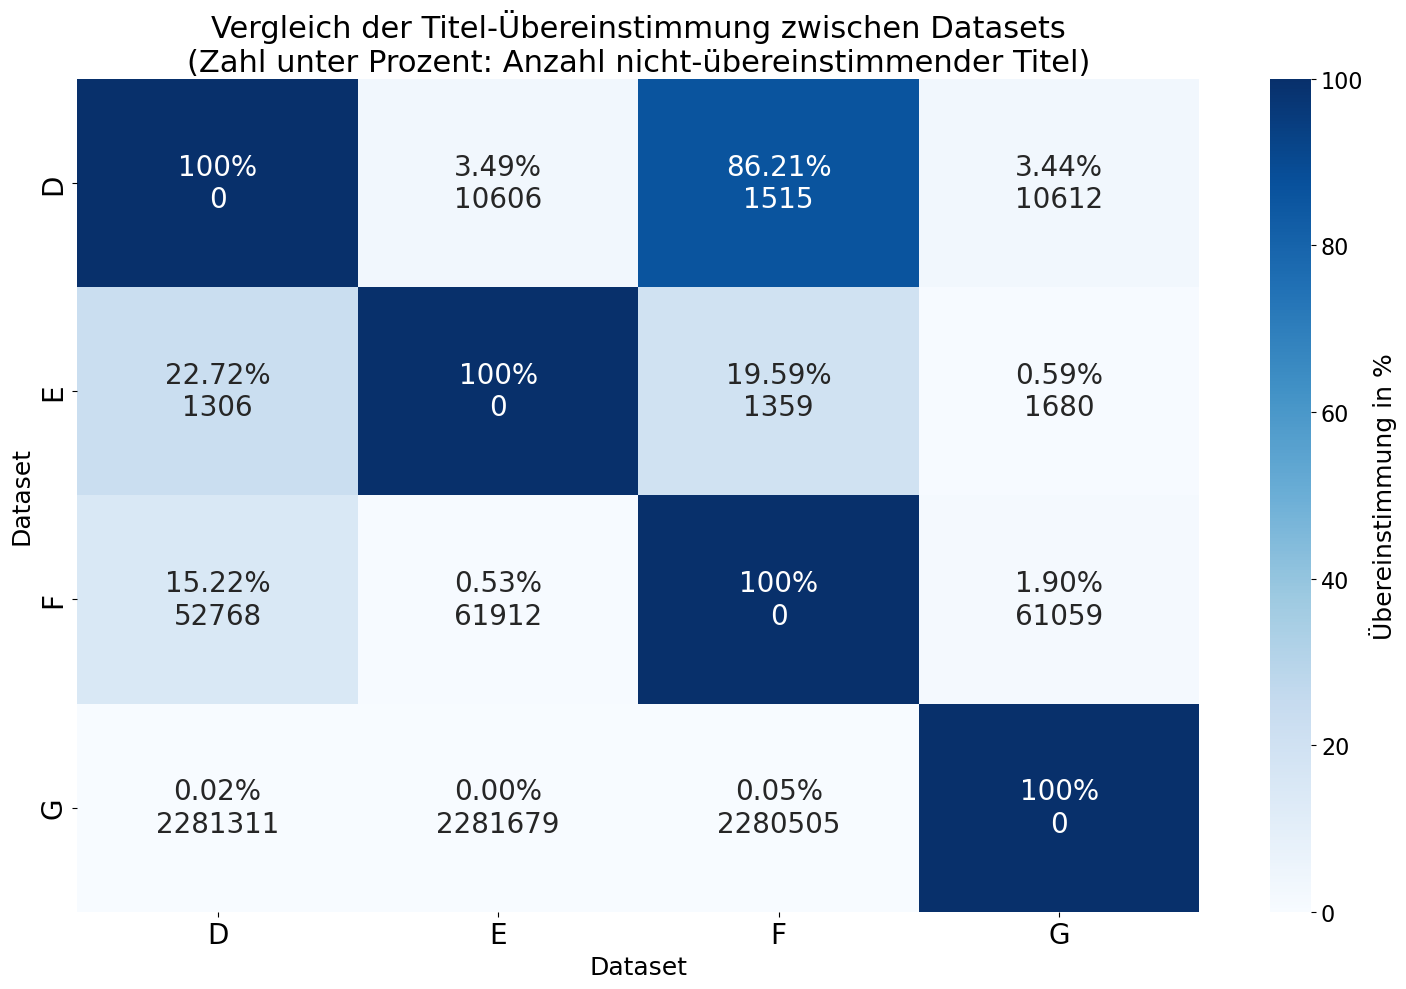

In [32]:
# After filtering
remove_keys = ['A', 'B', 'C']
result = result.drop(index=remove_keys, columns=remove_keys)
annot  = annot.drop(index=remove_keys, columns=remove_keys)

# Plot heatmap with larger labels and annotations
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    result.astype(float),
    annot=annot.values,
    fmt="",
    cmap='Blues',
    cbar_kws={'label': 'Übereinstimmung in %'},
    annot_kws={"fontsize": 20}  # Set annotation (cell text) size
)

plt.title(
    'Vergleich der Titel-Übereinstimmung zwischen Datasets\n'
    '(Zahl unter Prozent: Anzahl nicht-übereinstimmender Titel)',
    fontsize=22
)
plt.xlabel('Dataset', fontsize=18)
plt.ylabel('Dataset', fontsize=18)

# Tick label sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Colorbar label and ticks
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Übereinstimmung in %', fontsize=18)
cbar.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.show()


## Validierung auf diesen Datensätzen

In [48]:
import joblib
from sklearn.metrics import accuracy_score
import os
import pandas as pd

from datasets import load_dataset
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import accuracy_score


def load_datasets(basepath):
    """
    Load and clean individual fake news datasets from subfolders in basepath.
    Returns a dict of pandas DataFrames keyed by dataset name.
    """
    datasets = {}


    # 7. Meg Risdal_fake_only
    folder = os.path.join(basepath, "Meg Risdal_fake_only")
    df7 = pd.read_csv(os.path.join(folder, "fake.csv"))
    # Drop null titles and non‑English entries
    if 'titel' in df7.columns:
        df7 = df7.dropna(subset=['titel'])
        df7 = df7.rename(columns={'titel': 'title'})
    if 'language' in df7.columns:
        df7 = df7[df7['language'].str.lower() == 'english']
    # Assign label: fake-only → 0
    df7['label'] = 0
    df7 = df7.dropna(subset=['title', 'text'])
    df7 = df7[(df7['title'].str.strip() != '') & (df7['text'].str.strip() != '')]
    datasets['D'] = df7

    # 8. Ruchi Bhatia_news_articles.csv
    df8 = pd.read_csv(os.path.join(basepath, "Ruchi Bhatia_news_articles.csv/news_articles.csv"))
    
    # Clean entries
    df8 = df8[~df8['title'].str.lower().isin(['no title', 'newsticker'])]
    df8 = df8[df8['text'].notna()]
    
    # Filter for English language if column exists
    if 'language' in df8.columns:
        df8 = df8[df8['language'].str.lower() == 'english']
    
    # Map labels and drop NaNs that result from unmapped values
    df8['label'] = df8['label'].str.upper().map({
        'FAKE': 0,
        'REAL': 1
    })
    df8 = df8[df8['label'].notna()]  # <--- Remove rows where label is NaN
    
    datasets['E'] = df8
    
    # 9. Saurabh Shahane - Fake_News_Classification
    df9 = pd.read_csv(
        os.path.join(basepath, "Saurabh Shahane - Fake_News_Classification", "WELFake_Dataset.csv")
    )
    
    # Drop rows where text or title is NaN
    df9 = df9[df9['text'].notna() & df9['title'].notna()]
    df9['label'] = 1 - df9['label']
    
    datasets['F'] = df9


    return datasets

model_path = "../src/research/max/models/logreg_B.joblib"
model = joblib.load(model_path)
# Load all datasets fully
base_path = '../src/data'
datasets = load_datasets(base_path)
# Evaluate on each dataset individually
print("Evaluating model logreg_B_C_D.joblib on individual datasets:\n")
for name, df in datasets.items():
    X = df['title'] + '\n' + df['text']
    y = df['label']
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f"Dataset {name}: accuracy = {acc:.8f}")

Evaluating model logreg_B_C_D.joblib on individual datasets:

Dataset D: accuracy = 0.97078399
Dataset E: accuracy = 0.60470325
Dataset F: accuracy = 0.97827698


## Lade Datensatz g in Chunks damit er in RAM passt

In [41]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# adjust to wherever you keep your large CSV
BIG_DATA_CSV = "../src/data/bigFakeNews/dataFiltered.csv"

# chunk size for the big dataset
CHUNKSIZE = 200_000
model_path = "../src/research/max/models/logreg_B.joblib"
model = joblib.load(model_path)
print("Evaluating large dataset in chunks:\n")

total_rows = 0
total_correct = 0


for chunk_idx, chunk in enumerate(
        pd.read_csv(BIG_DATA_CSV, 
                    usecols=["title", "text", "label"],  # only load what we need
                    chunksize=CHUNKSIZE)
    ):

    # Predict
    X_chunk = chunk["title"] + "\n" + chunk["text"]
    y_chunk = chunk["label"].values
    y_pred_chunk = model.predict(X_chunk)

    # Accumulate
    correct = np.sum(y_pred_chunk == y_chunk)
    n = len(y_chunk)
    total_correct += correct
    total_rows += n

    # Progress message
    print(f"  • Chunk {chunk_idx+1}: processed {n} rows, "
          f"cumulative: {total_rows} rows, "
          f"chunk accuracy = {correct/n:.4f}")

# Final accuracy
final_acc = total_correct / total_rows
print(f"\nOverall accuracy on '{os.path.basename(BIG_DATA_CSV)}': {final_acc:.8f}")

Evaluating large dataset in chunks:

  • Chunk 1: processed 200000 rows, cumulative: 200000 rows, chunk accuracy = 0.8079
  • Chunk 2: processed 200000 rows, cumulative: 400000 rows, chunk accuracy = 0.7037
  • Chunk 3: processed 200000 rows, cumulative: 600000 rows, chunk accuracy = 0.7735
  • Chunk 4: processed 200000 rows, cumulative: 800000 rows, chunk accuracy = 0.5574
  • Chunk 5: processed 200000 rows, cumulative: 1000000 rows, chunk accuracy = 0.7960
  • Chunk 6: processed 200000 rows, cumulative: 1200000 rows, chunk accuracy = 0.6020
  • Chunk 7: processed 200000 rows, cumulative: 1400000 rows, chunk accuracy = 0.7361
  • Chunk 8: processed 200000 rows, cumulative: 1600000 rows, chunk accuracy = 0.5901
  • Chunk 9: processed 200000 rows, cumulative: 1800000 rows, chunk accuracy = 0.7300
  • Chunk 10: processed 200000 rows, cumulative: 2000000 rows, chunk accuracy = 0.7036
  • Chunk 11: processed 200000 rows, cumulative: 2200000 rows, chunk accuracy = 0.6935
  • Chunk 12: proce

## Trainieren auf Datensatz G Chunk für Chunk

In [42]:
import pandas as pd
import numpy as np

# Train/validation split
from sklearn.model_selection import train_test_split

# Text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Classifier and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pipeline utilities
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

# Parameters
CSV_PATH = "../src/data/bigFakeNews/dataFiltered.csv"
CHUNK_SIZE = 100_000  # or tune to your memory limit





In [43]:
# Initialize
vectorizer = HashingVectorizer(
    n_features=20000,
    alternate_sign=False,
    ngram_range=(1,2),
    stop_words='english'
)
clf = SGDClassifier(loss='log_loss', max_iter=1, tol=None, warm_start=True)

In [44]:
# First pass: partial fit on labeled chunks
classes = [0, 1]  # replace with your actual label set (e.g. ['Real', 'Fake'] → [0,1])
for chunk in pd.read_csv(CSV_PATH, sep=',', chunksize=CHUNK_SIZE):
    texts = (chunk['title'] + "\n" + chunk['text']).tolist()
    X_chunk = vectorizer.transform(texts)
    y_chunk = chunk['label'].values
    clf.partial_fit(X_chunk, y_chunk, classes=classes)

# Second pass: evaluate on a held‑out chunk
test_chunk = next(pd.read_csv(CSV_PATH, sep=',', chunksize=CHUNK_SIZE))
X_test = vectorizer.transform((test_chunk['title'] + "\n" + test_chunk['text']).tolist())
y_test = test_chunk['label'].values
preds = clf.predict(X_test)
print("Chunk Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

Chunk Accuracy: 0.92817
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     64929
           1       0.85      0.96      0.90     35071

    accuracy                           0.93    100000
   macro avg       0.92      0.94      0.92    100000
weighted avg       0.93      0.93      0.93    100000



## Logisticregression für BBC-News

In [47]:
# 2. Imports
import joblib
from datasets import load_dataset, get_dataset_config_names
from sklearn.metrics import accuracy_score
# 3. Load the pre-trained fake news detection model
model_path = "../src/research/max/models/logreg_B.joblib"
model = joblib.load(model_path)
print(f"Loaded model from {model_path}\n")
# 4. Retrieve all available month configurations
dataset_name = 'RealTimeData/bbc_news_alltime'
all_months = get_dataset_config_names(dataset_name)
print(f"Found {len(all_months)} month configurations: {all_months}\n")
# 5. Evaluate per month and accumulate overall
results = []
all_true = []
all_pred = []

for month in sorted(all_months):
    # Load dataset for the given month
    ds = load_dataset(dataset_name, month)
    data = ds["train"]
    # Assume dataset has 'train' split and fields 'text' and 'label'

    # Predict
    texts = [t + "\n" + c for t, c in zip(data["title"], data["content"])]
    preds = model.predict(texts)

    true_labels = [1] * len(preds)
    # Compute accuracy for this month
    acc = accuracy_score(true_labels, preds)
    results.append({'month': month, 'accuracy': acc})

    # Accumulate for overall
    all_true.extend(true_labels)
    all_pred.extend(preds)

    print(f"Month {month}: Accuracy = {acc:.4f}")

Loaded model from ../src/research/max/models/logreg_B.joblib

Found 101 month configurations: ['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '20

In [49]:
# 6. Compute overall accuracy
overall_acc = accuracy_score(all_true, all_pred)
print(f"\nOverall accuracy across all months: {overall_acc:.4f}")



Overall accuracy across all months: 0.6036


## Logisticregression für BBC trainiert auf Datensatz G

In [54]:
# 2. Imports
import joblib
from datasets import load_dataset, get_dataset_config_names
from sklearn.metrics import accuracy_score

# 3. Load the pre-trained fake‑news detection model + vectorizer
model_path = "../src/research/max/sgd_news_classifier.pkl"
vectorizer_path = "../src/research/max/hashing_vectorizer.pkl"

model = joblib.load(model_path)
vectorizer = joblib.load(vectorizer_path)
print(f"Loaded model from {model_path}")
print(f"Loaded vectorizer from {vectorizer_path}\n")

# 4. Retrieve all available month configurations
dataset_name = 'RealTimeData/bbc_news_alltime'
all_months = get_dataset_config_names(dataset_name)
print(f"Found {len(all_months)} month configurations: {all_months}\n")

# 5. Evaluate per month and accumulate overall
results = []
all_true = []
all_pred = []

for month in sorted(all_months):
    # Load dataset for the given month
    ds = load_dataset(dataset_name, month)
    data = ds["train"]

    # Build the raw texts (title + content)
    texts = [t + "\n" + c for t, c in zip(data["title"], data["content"])]

    # --- NEW: vectorize before predicting ---
    X = vectorizer.transform(texts)
    preds = model.predict(X)
    # ------------------------------------------

    # True labels (all real ⇒ 1)
    true_labels = [1] * len(preds)

    # Compute accuracy for this month
    acc = accuracy_score(true_labels, preds)
    results.append({'month': month, 'accuracy': acc})

    # Accumulate for overall
    all_true.extend(true_labels)
    all_pred.extend(preds)

    print(f"Month {month}: Accuracy = {acc:.4f}")

# (Optional) print overall accuracy
overall_acc = accuracy_score(all_true, all_pred)
print(f"\nOverall accuracy across all months: {overall_acc:.4f}")


Loaded model from ../src/research/max/sgd_news_classifier.pkl
Loaded vectorizer from ../src/research/max/hashing_vectorizer.pkl

Found 101 month configurations: ['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2

In [55]:
# 6. Compute overall accuracy
overall_acc = accuracy_score(all_true, all_pred)
print(f"\nOverall accuracy across all months: {overall_acc:.4f}")



Overall accuracy across all months: 0.6752


## Ausblick
---